# Random Forest (Regression)

This notebook implements the custom random forest algorithm for regression on the Palmer Penguins dataset. Here, a random forest regressor is used to predict bill length based on input data for various numerical features, including bill width, flipper length, and body mass. The objective of this task is to validate the use of the custom random forest class for regression, and evaluate its performance for a multi-feature regression problem with a single target variable.

The following sections are included in this notebook:
1. **Library Imports**
- Importing the necessary modules, packages, and libraries
- Specifies dependencies and preferred versions
2. **Data Loading and Cleaning**
- Loads the Palmer Penguins dataset with relevant features
- Drops outliers, duplicates, and missing data
- Creates arrays for the features and target variable
3. **Data Visualization**
- Visualizes the correlation between features using a heatmap
- Visualizes the distribution of two features with the target on a 2D color plot
4. **Random Forest Implementation (2 Features)**
- Implements the custom-built random forest algorithm with two input features  
- Visualizes the regression results  
- Evaluates the results across multiple metrics  
5. **Random Forest Implementation (Changing Parameters)**
- Implements the custom-built random forest algorithm with various parameters (number of trees, maximum depth, minimum samples to split)
- Examines the effect on model performance
6. **Random Forest Implementation (Multiple Features)**
- Implements the custom-built random forest algorithm with more than two features to ensure functionality
- Evaluates the results across multiple metrics
- Compares the effects of changing the maximum feature parameter
7. **Comparison with Existing Models**
- Runs the scikit-learn version of random forest
- Compares the results with the custom-built class to verify the latter

*For a more comprehensive overview of the random forest algorithm, code structure, and metrics used, see the associated [README](README.md).*

### Library Imports
This section imports the packages and modules required to run the random forest algorithm. The following dependencies (with recommended versions) are required:
- Python 3.9.6
- Numpy 1.26.4
- Pandas 2.3.3
- Matplotlib 3.9.4
- Seaborn 0.13.2

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.supervised_learning.randomforest import *
from rice_ml.postprocess.regressionpost import *

### Data Loading & Cleaning
*Loading, preprocessing, and dividing data*

The data used in this notebook comes from Palmer Penguins. Although this dataset is typically used for classification algorithms, it can be adapted to evaluate regression, as it contains a set of numerical features with some relation to one another. It has been selected for its simplicity and clear feature relationships, and because it requires several data cleaning steps that showcase the `rice_ml` preprocessing modules, including handling missing values. The features of interest in this example are *flipper length* (numeric), *bill length* (numeric and the target variable for regression), *bill depth* (numeric), and *body mass* (numeric). 

The data is first loaded as a Pandas DataFrame. Because no variables are categorical, no addition conversion of data is required.

In [76]:
# Loading the basic dataset and selecting features
penguins_df = sns.load_dataset("penguins")
penguin_features = penguins_df[[
    "bill_length_mm", 
    "bill_depth_mm", 
    "flipper_length_mm", 
    "body_mass_g"
]]

display(penguin_features)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0
...,...,...,...,...
339,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


The dataset contains some missing or NaN values (e.g., row 4) and may contain outlier or duplicate rows that will skew the results of the regression. To clean the data, we apply a series of preprocessing steps from the `rice_ml` preprocessing package, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another.

In [77]:
# Cleaning the dataset (dropping rows with missing values, duplicates, or containing outliers)
penguin_features_cleaned_missing = missing_data(penguin_features, 'drop')
penguin_features_cleaned_outliers = outlier_identify(penguin_features_cleaned_missing, 'zscore', drop = True)
penguin_features_cleaned = duplicate_identify(penguin_features_cleaned_outliers, True)
print(f"Cleaned data (first five rows): \n {penguin_features_cleaned[0:5, :]}")

Cleaned data (first five rows): 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


Two rows have been removed during cleaning, and the dataset no longer contains NaN values. For use in KNN regression and for ease of visualization, the dataset must be split into the target (*bill length*) and the remaining features.

In [78]:
# Creating two arrays
bill_length = penguin_features_cleaned[:, 0]
penguin_feature_data = penguin_features_cleaned[:, 1:]
print(f"Array for bill length (first five entries): \n {bill_length[0:5]} \n \n \
Array for penguin feature data (first five rows): \n {penguin_feature_data[0:5]}")

Array for bill length (first five entries): 
 [39.1 39.5 40.3 36.7 39.3] 
 
 Array for penguin feature data (first five rows): 
 [[  18.7  181.  3750. ]
 [  17.4  186.  3800. ]
 [  18.   195.  3250. ]
 [  19.3  193.  3450. ]
 [  20.6  190.  3650. ]]


### Data Visualization
*Correlations and feature plotting*

Once the data has been appropriately cleaned, the relationships between variables can be visualized using a set of methods. We first visualize the correlations between features using a heatmap of a calculated correlation matrix, applied to the cleaned DataFrame that includes all relevant features. Doing so allows for the identification of features that are correlated with the target, and may thus be appropriate for regression using random forest.

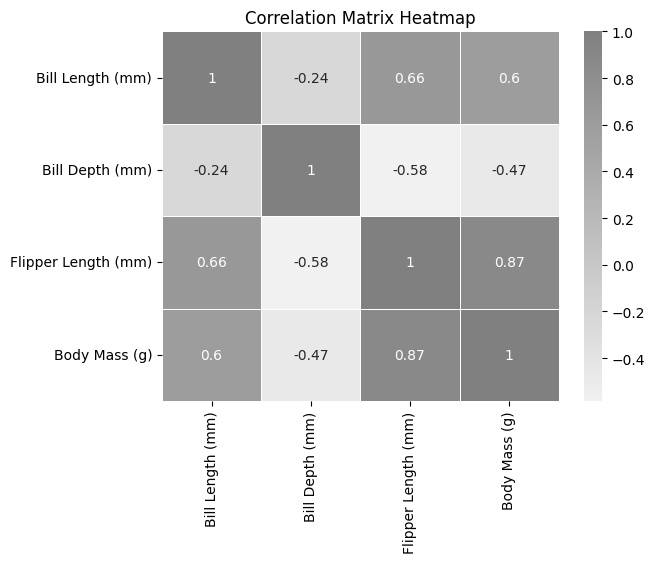

In [79]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(penguin_features_cleaned, columns = ['Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'])).corr()
sns.heatmap(correlation_matrix, annot = True, cmap=sns.light_palette('gray', as_cmap=True), linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

To predict bill length, we select bill depth and flipper length as the features of interest, as they are correlated with the former (-0.24 and 0.66, respectively). The relationship between these features can be visualized using a two-dimensional plot and color mappings that correspond to a range of bill length values.

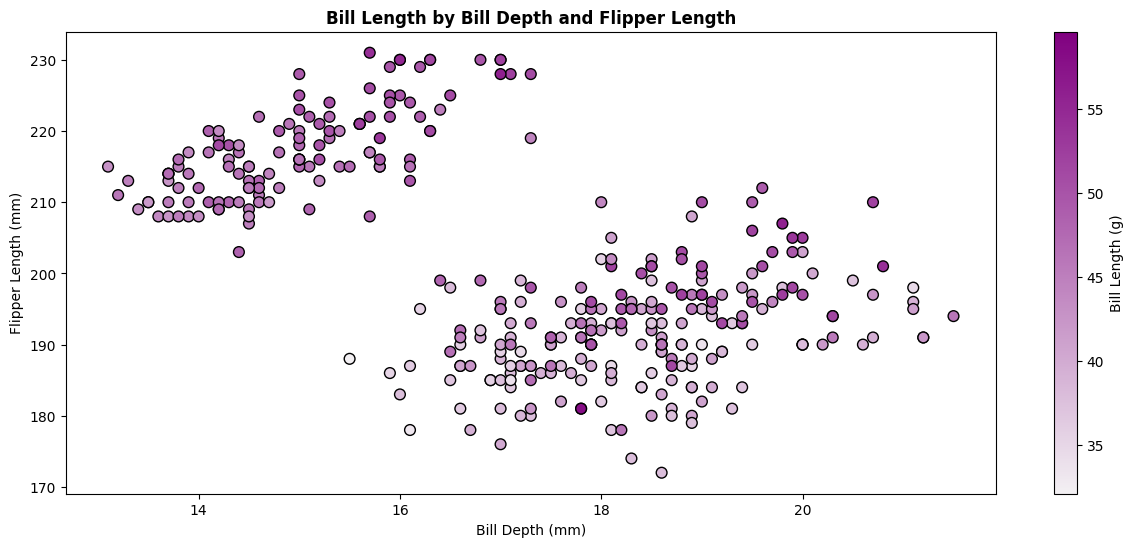

In [80]:
# Plotting bill depth and flipper length, color-coded by bill length
plt.figure(figsize = (15, 6))
plt.scatter(penguin_feature_data[:, 0], penguin_feature_data[:, 1], c = bill_length, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
cbar = plt.colorbar()
cbar.set_label("Bill Length (g)")
plt.xlabel("Bill Depth (mm)")
plt.ylabel("Flipper Length (mm)")
plt.title("Bill Length by Bill Depth and Flipper Length", fontweight = 'bold')
plt.show()

Bill depth and flipper length appear to form two separate clusters, one with a larger bill depth but smaller flipper length and vice versa. Bill length tends to have a negative correlation with bill depth, increasing as bill depth decreases. However, it has a positive relationship with flipper length, increasing as the latter increases. The distribution of this data and the visible trends suggest that it is a good candidate for evaluating the custom random forest regression algorithm.

### Random Forest Implementation (2 Features)
*Regression using random forest with two features*

This section implements the custom random forest regressor to predict bill length based on flipper length and bill width. It carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the random forest model, we normalize the feature data using z-scores for each feature, calculated using the `preprocessing` package. This reduces the possibility that the relative scale of the feature will impact model results, and is standard practice in supervised learning. Feature normalization rescales each feature to prevent skewing results based on feature magnitude, ensuring that no one feature will overly contribute to model predictions.

In [81]:
# Standardizing the features
penguin_feature_data_normal = z_score_standardize(penguin_feature_data[:, [0, 1]])
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal[0:5, :]}")

Standardized feature data (first five rows): 
 [[ 0.78544923 -1.41834665]
 [ 0.1261879  -1.06225022]
 [ 0.43046236 -0.42127665]
 [ 1.08972369 -0.56371522]
 [ 1.74898502 -0.77737308]]


Once the data has been scaled, it is split into testing and training arrays. This ensures that the model is not trained and tested on the same set of data, allowing for unbiased evaluation of model performance and preventing overfitting. The data is split in a 70/30 proportion such that the training data is 70% of the total dataset, and the testing data 30%. There are 342 samples in the cleaned dataset, so the training array should have approximately 239/240 samples and the testing should have 102/103. Because this is a regression problem with no class labels, stratification (as done in [decision trees](decision_tree_example.ipynb)) is not applicable, and the basic `train_test` function is used.

In [82]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, bill_length, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (239, 2)
Shape of training targets: (239,)
Shape of testing array: (103, 2)
Shape of testing targets: (103,)


We now perform regression using random forest by creating an instance of the `random_forest` class from the supervised learning package, and fitting it on the training data. The previously unseen test data is then provided to the fitted model to predict the body mass of a sample. 

This random forest regressor has the following specifications:
- **Number of Trees:** 100
- **Task:** Regression
- **Maximum Depth:** None
- **Minimum Samples to Split:** 2
- **Maximum Features:** Square Root
- **Random State:** None

In [100]:
# Fitting the model
forest = random_forest(n_trees = 100, task = 'regression')
forest.fit(train_array, train_targets)

# Predicting bill length based on testing data
prediction = forest.prediction(test_array)

When the model has been successfully fitted and returns the bill length predictions for the test data, we evaluate its performance using a variety of visualization and scoring methods. These include plotting the predictions and calculating the MAE, MSE, RMSE, R2, and adjusted R2. For a description of these metrics, see this [README](README.md).

The plot below is a visualization of the random forest regressor on the test data. The leftmost subplot displays the overall distribution of bill depth and flipper length for the test data, color-coded for gold-standard bill length on a gradient scale. The rightmost subplot displays the same test data, but the gradient values are based on the value predictions from the regression tree.

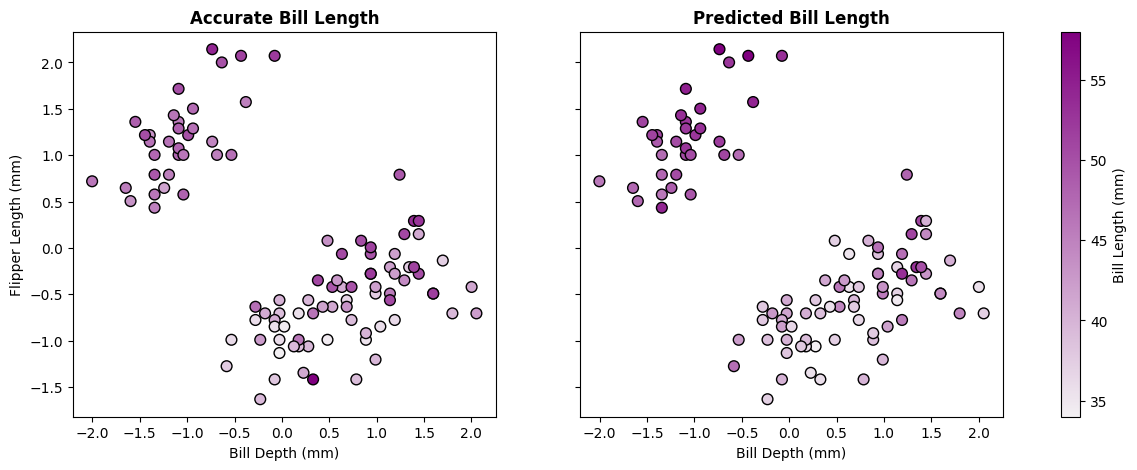

In [84]:
# Plotting bill depth and flipper length for actual and predicted data, color-coded by bill length

fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = True)
plot_1 = ax[0].scatter(test_array[:, 0], test_array[:, 1], c = test_targets, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
ax[0].set_xlabel("Bill Depth (mm)")
ax[0].set_ylabel("Flipper Length (mm)")
ax[0].set_title("Accurate Bill Length", fontweight = 'bold')

plot_2 = ax[1].scatter(test_array[:, 0], test_array[:, 1], c = prediction, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
ax[1].set_xlabel("Bill Depth (mm)")
ax[1].set_title("Predicted Bill Length", fontweight = 'bold')

cbar = fig.colorbar(plot_1, ax = ax, location = 'right')
cbar.set_label("Bill Length (mm)")
plt.show()

The custom random forest has a relatively poor fit for the test data, predicting values at greater extremes than the true values. To quantitatively evaluate the model, we print the relevant performance metrics.

In [85]:
# Evaluating the model
print_model_metrics(prediction, test_targets, n_features = 2)

Model Metrics 
------------- 
MAE: 3.84 
MSE: 24.65 
RMSE: 4.96 
R2: 0.14 
Adjusted R2: 0.13


The evaluation metrics do not indicate that the random forest regressor is able to predict bill length from bill depth and flipper length, with a low R2 and adjusted R2 value (~0.14). Each error calculation is fairly high, which suggests that the selected features are not sufficient for accurate prediction. We will determine whether the model can be improved by systematically varying the hyperparameters.

### Random Forest Implementation (Changing Parameters)
*Altering number of trees, maximum depth, and minimum samples to split*

This section implements the custom random forest regressor for predicting bill length based on bill depth and flipper length, but systematically changes a parameter in the model to determine the effects on performance. It first evaluates the model for different numbers of trees, using R2 as the primary metric.

In [101]:
# Arrays for number of trees and R2
tree_values = np.arange(1, 500, 50)
r2_trees = np.full(len(tree_values), np.nan)

# Fitting and scoring the model for each number of trees
for i in range(len(tree_values)):
    forest = random_forest(n_trees = int(tree_values[i]), task = 'regression')
    forest.fit(train_array, train_targets)
    prediction = forest.prediction(test_array)
    r2_score = r2(prediction, test_targets)
    r2_trees[i] = r2_score

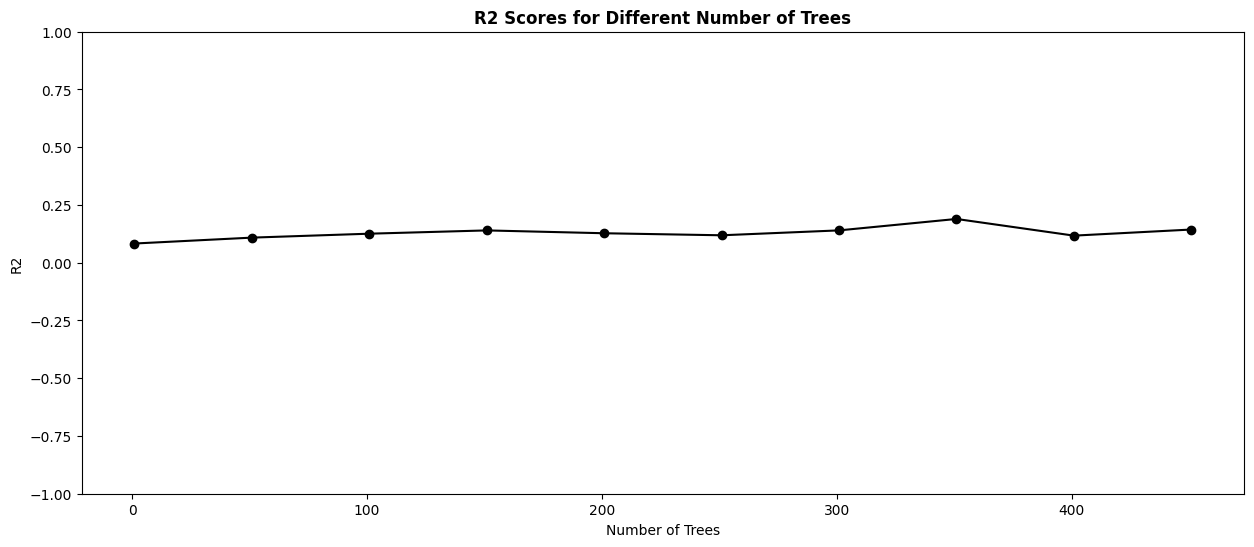

In [102]:
# Plotting the change in R2 across different number of trees
plt.figure(figsize = (15, 6))
plt.plot(tree_values, r2_trees, 'black')
plt.scatter(tree_values, r2_trees, color = 'black')
plt.title("R2 Scores for Different Number of Trees", fontweight = 'bold')
plt.xlabel("Number of Trees")
plt.ylabel("R2")
plt.ylim(-1, 1)
plt.show()

As the number of trees included in the random forest regressor increases, the R2 score increases slightly, but does not show a significant improvement. This suggests that the number of trees is not significantly affecting the model performance in this instance; we will select the default 100 trees to preserve computational efficiency in future analysis.

We now evaluate the model for different maximum depths, using R2 as the primary metric.

In [104]:
# Arrays for maximum depth and R2
max_depth_values = np.arange(1, 11)
r2_max_depth = np.full(len(max_depth_values), np.nan)

# Fitting and scoring the model for each maximum depth
for i in range(len(max_depth_values)):
    forest = random_forest(n_trees = 100, task = 'regression', max_depth = int(max_depth_values[i]))
    forest.fit(train_array, train_targets)
    prediction = forest.prediction(test_array)
    r2_score = r2(prediction, test_targets)
    r2_max_depth[i] = r2_score

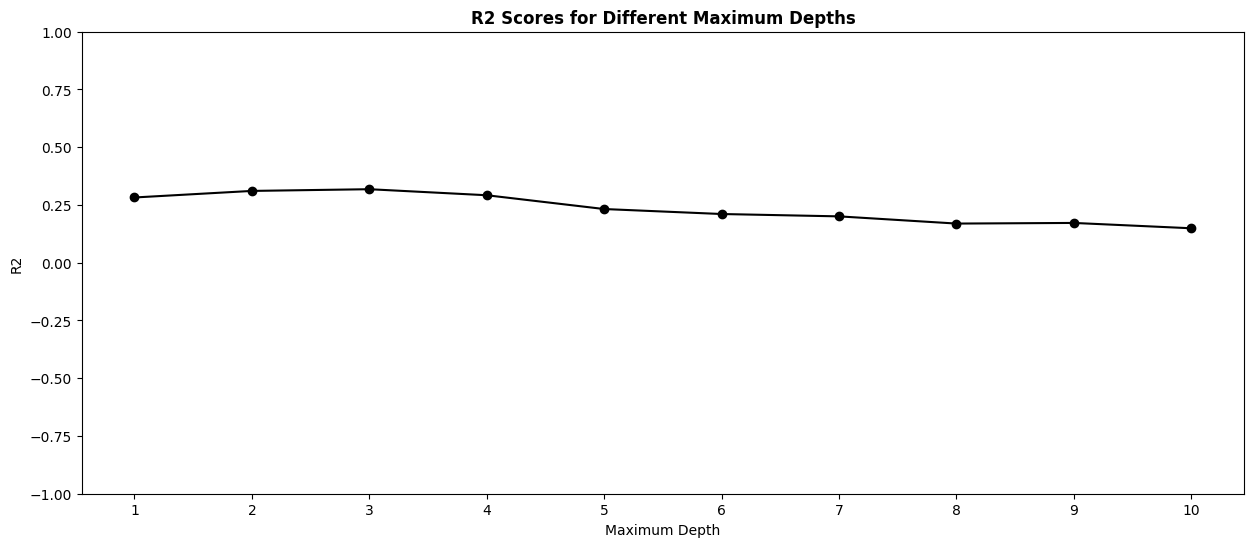

In [105]:
# Plotting the change in R2 across different maximum depths
plt.figure(figsize = (15, 6))
plt.plot(max_depth_values, r2_max_depth, 'black')
plt.scatter(max_depth_values, r2_max_depth, color = 'black')
plt.title("R2 Scores for Different Maximum Depths", fontweight = 'bold')
plt.xlabel("Maximum Depth")
plt.ylabel("R2")
plt.ylim(-1, 1)
plt.xticks(range(1, 11))
plt.show()

The maximum depth of the tree in the random forest regressor does not appear to significantly impact R2 values, although a slight downward trend is occasionally observed as the maximum depth increases. As with the number of trees, this provides little information as to the optimal value for this parameter, but we will set the maximum depth to 3 for future analysis.

We now evaluate model performance with various values for the minimum samples required to split a node, with R2 as the metric.

In [106]:
# Arrays for minimum samples to split
min_samples_values = np.arange(1, 11)
r2_min_samples = np.full(len(min_samples_values), np.nan)

# Fitting and scoring the model for each minimum sample
for i in range(len(min_samples_values)):
    forest = random_forest(n_trees = 100, task = 'regression', max_depth = 3, min_samples_split = int(min_samples_values[i]))
    forest.fit(train_array, train_targets)
    prediction = forest.prediction(test_array)
    r2_score = r2(prediction, test_targets)
    r2_min_samples[i] = r2_score

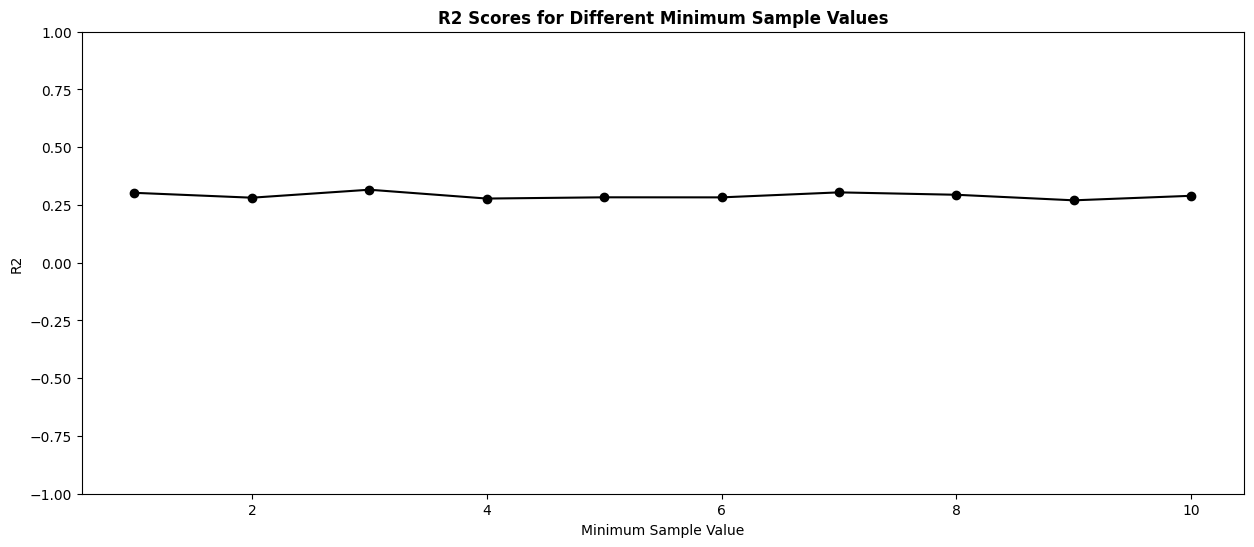

In [ ]:
# Plotting the change in R2 across different minimum split samples
plt.figure(figsize = (15, 6))
plt.plot(min_samples_values, r2_min_samples, 'black')
plt.scatter(min_samples_values, r2_min_samples, color = 'black')
plt.title("R2 Scores for Different Minimum Sample Values", fontweight = 'bold')
plt.xlabel("Minimum Sample Value")
plt.ylabel("R2")
plt.ylim(-1, 1)
plt.show()

As before, the value set for the minimum samples needed to split a node does not significantly change the R2 of the model, although it appears to have been improved by using the previously established values for the remaining hyperparameters. In this case, we select the minimum sample value to remain at the default of 2 for the rest of the analysis.

### Random Forest Implementation (Multiple Features)
*Regression using random forest with multiple (three) features*

This section implements the custom random forest class to predict bill length based on bill depth, flipper length, and body mass. As before, it carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the random forest model, we normalize the feature data using z-scores for each feature, again calculated using the `preprocessing` package. In this case, the entire feature data set (not simply the two selected features) is normalized and used in the random forest analysis. The data is then split into training (70%) and testing arrays (30%). Finally, a new instance of the random forest class is created and fit with the training data, then used to predict target values for the testing data.

This random forest regressor has the following specifications:
- **Number of Trees:** 100
- **Task:** Regression
- **Maximum Depth:** 3
- **Minimum Samples to Split:** 2
- **Maximum Features:** Square Root
- **Random State:** None

In [108]:
# Standardizing the features
penguin_feature_data_mult = z_score_standardize(penguin_feature_data)
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_mult[0:5, :]}")   

Standardized feature data (first five rows): 
 [[ 0.78544923 -1.41834665 -0.56414208]
 [ 0.1261879  -1.06225022 -0.50170305]
 [ 0.43046236 -0.42127665 -1.18853234]
 [ 1.08972369 -0.56371522 -0.93877623]
 [ 1.74898502 -0.77737308 -0.68902013]]


In [110]:
# Splitting the data into training and testing arrays
train_array_mult, test_array_mult, train_targets_mult, test_targets_mult = train_test(penguin_feature_data_mult, bill_length, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array_mult.shape}")
print(f"Shape of training targets: {train_targets_mult.shape}")
print(f"Shape of testing array: {test_array_mult.shape}")
print(f"Shape of testing targets: {test_targets_mult.shape}")

Shape of training array: (239, 3)
Shape of training targets: (239,)
Shape of testing array: (103, 3)
Shape of testing targets: (103,)


In [111]:
# Fitting the model
forest_mult = random_forest(100, 'regression', max_depth = 3)
forest_mult.fit(train_array_mult, train_targets_mult)

# Predicting species based on testing data
prediction_mult = forest_mult.prediction(test_array_mult)

Model evaluation for three features is done using the quantitative metrics.

In [112]:
# Evaluating the model
print_model_metrics(prediction_mult, test_targets_mult, n_features = 3)

Model Metrics 
------------- 
MAE: 3.29 
MSE: 19.29 
RMSE: 4.39 
R2: 0.33 
Adjusted R2: 0.31


This model is more accurate than the model that only included two features with hyperparameters that were not tuned, indicating a benefit to performance by including multiple features, and selecting a specific number of trees and maximum depth. However, the R2 value remains fairly low (~0.33), which suggests that bill length is not well-predicted by the remaining numeric features. We will determine whether using different metrics for determining maximum features considered changes the results of the model, with R2 as the metric.

In [113]:
# Arrays for maximum number of features
max_features = [1, 2, 3, 'sqrt', 'log2']
r2_max_features = np.full(len(max_features), np.nan)

# Fitting and scoring the model for each feature division
for i in range(len(max_features)):
    forest = random_forest(n_trees = 100, task = 'regression', max_depth = 3, max_features = max_features[i])
    forest.fit(train_array_mult, train_targets_mult)
    prediction_mult_test = forest.prediction(test_array_mult)
    r2_score = r2(prediction_mult_test, test_targets_mult)
    r2_max_features[i] = r2_score

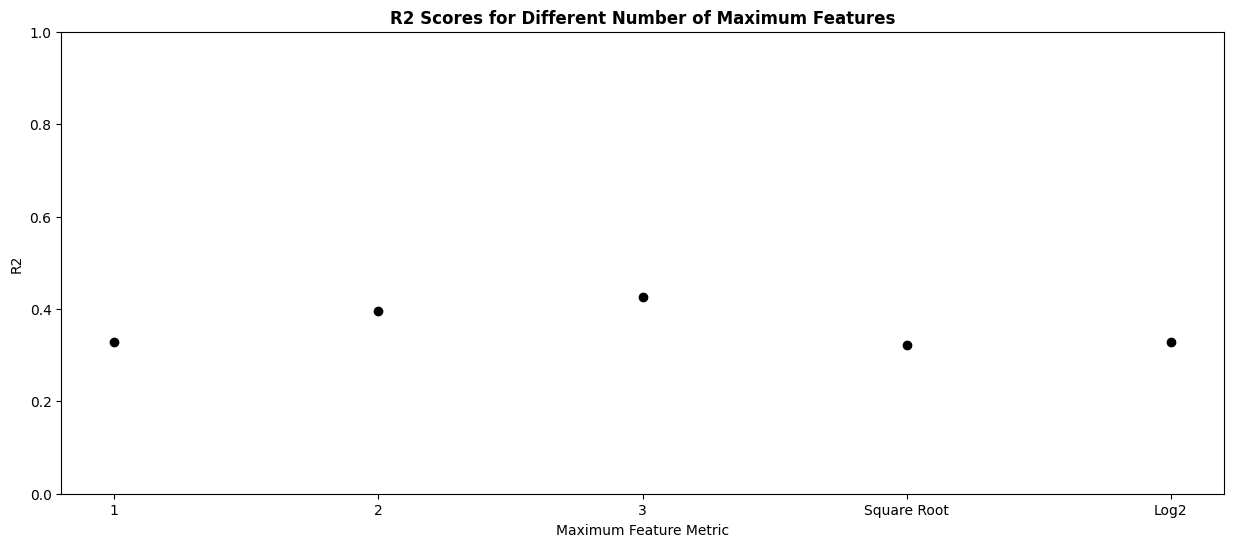

In [117]:
# Plotting the change in accuracy across different maximum features
plt.figure(figsize = (15, 6))
plt.scatter(['1', '2', '3', 'Square Root', 'Log2'], r2_max_features, color = 'black')
plt.title("R2 Scores for Different Number of Maximum Features", fontweight = 'bold')
plt.xlabel("Maximum Feature Metric")
plt.ylabel("R2")
plt.ylim(0, 1)
plt.show()

Changing the way in which the maximum features for a tree is determined has some effect on model fit, although it is not particularly pronounced. As the number of features increases, the R2 of the model increases as well, but within a limited range. The square root and log2 metrics appear to be functional, but do not result in a particular benefit to model performance.

### Comparison with Existing Models
*Comparison with scikit-learn random forest*

In order to ensure that the custom-built random forest regressor is functioning as intended and providing expected results, it is useful to compare its performance to a random forest regressor from established code, especially considering the fairly low R2 scores produced by this model. In this section, we rerun the analysis with all three features using the scikit-learn random forest regressor with a matching number of trees (100), maximum depth (3), minimum samples to split (2), and maximum features (square root) to verify the results of the custom model.

In [118]:
from sklearn.ensemble import RandomForestRegressor
forest_sk = RandomForestRegressor(n_estimators = 100, max_depth = 3, min_samples_split = 2, max_features = 'sqrt')
forest_sk.fit(train_array_mult, train_targets_mult)
prediction_sk = forest_sk.predict(test_array_mult)

In [119]:
print_model_metrics(prediction_sk, test_targets_mult)

Model Metrics 
------------- 
MAE: 3.08 
MSE: 17.65 
RMSE: 4.20 
R2: 0.39 
Adjusted R2: 0.38


The results of the scikit-learn random forest regressor match those of the custom-build model. Although the R2 remains low (~0.39), this suggests that the selected features are not particularly suitable for regression rather than indicating a defect in the custom random forest regressor. Therefore, the custom `rice_ml` random forest regressor is able to reproduce the results from models that have been established at a professional level, validating its use in multi-feature regression.

